In [ ]:
# default_exp embeddings
# hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

# DeepWalk with Backwards Connections Directed Graphs

In this notebook, we will compare the performance of the original DeepWalk and Node2Vec algorithm and a new, more flexible version of the algorithms with backwards connection on directed graphs.

## Random Walker and Biased Random Walker

The algorithm for `DeepWalk` and `Node2Vec` is identical, except it replaces `RandomWalker` with `BiasedRandomWalker`.

First, we will reimplement the algorithm to allow it to accept any kind of Random Walker.

In [ ]:
import numpy as np
import networkx as nx
from gensim.models.word2vec import Word2Vec
from karateclub.estimator import Estimator

class DeepWalkAugmented(Estimator):
    def __init__(self, walker, dimensions=128, workers=4, window_size=5, epochs=1, learning_rate=0.05, min_count=1, seed=42):
        self.walker = walker
        self.dimensions = dimensions
        self.workers = workers
        self.window_size = window_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.min_count = min_count
        self.seed = seed

    def fit(self, graph, backwards_graph=None):
        self._set_seed()
        walker = self.walker
        graph = self._check_graph(graph)
        if backwards_graph is None:
            walker.do_walks(graph)
        else:
            backwards_graph = self._check_graph(backwards_graph)
            walker.do_walks(graph, backwards_graph)
        model = Word2Vec(
            walker.walks,
            hs=1,
            alpha=self.learning_rate,
            epochs=self.epochs,
            vector_size=self.dimensions,
            window=self.window_size,
            min_count=self.min_count,
            workers=self.workers,
            seed=self.seed,
        )
        num_of_nodes = graph.number_of_nodes()
        self._embedding = [model.wv[str(n)] for n in range(num_of_nodes)]

    def get_embedding(self) -> np.array:
        return np.array(self._embedding)

Let try applying the original DeepWalk on a Source graph and a Sink graph.

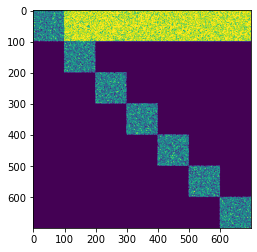

In [ ]:
from directed_graphs.datasets import source_graph
import torch
import matplotlib.pyplot as plt
dataset = source_graph(n_points = 700, num_clusters=7)
data = dataset[0]
sparse_A = torch.sparse_coo_tensor(data.edge_index, torch.ones(data.edge_index.shape[1]))
A = sparse_A.to_dense()
plt.imshow(A)

In [ ]:
from torch_geometric.utils import to_networkx
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_graph_embedding(data, n_clusters, model):
  print("converting graph to networkx...")
  G_nx = to_networkx(data, to_undirected=False)
  
  print("getting embedding...")
  model.fit(G_nx)
  embedding = model.get_embedding()
  print(f"Embedding shape = {embedding.shape}")

  print("performing PCA...")
  pca = PCA(n_components=2)
  pca_out= pca.fit_transform(embedding)
  clusters = np.repeat(list(range(n_clusters)), data.x.shape[1]/n_clusters)
  sc = plt.scatter(pca_out[:, 0], pca_out[:, 1], c=clusters)
  plt.legend(handles = sc.legend_elements()[0], title="Blobs", labels=list(range(n_clusters)))
  plt.show()
  

converting graph to networkx...
getting embedding...
Embedding shape = (700, 64)
performing PCA...


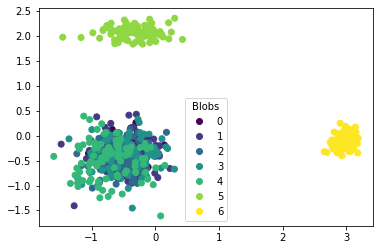

In [ ]:
from karateclub.utils.walker import RandomWalker
walker = RandomWalker(walk_number=10, walk_length=1000)
model = DeepWalkAugmented(walker, dimensions=64, window_size=5)
plot_graph_embedding(data, 7, model)

Let try adding backwards connection to RandomWalk.

In [ ]:
import random
from functools import partial
from typing import List, Callable

import numpy as np
import networkx as nx


class BackwardsRandomWalker:
    def __init__(self, walk_length: int, walk_number: int, backwards_prob: float = 0.05):
        self.walk_length = walk_length
        self.walk_number = walk_number
        self.backwards_prob = backwards_prob

    def do_walk(self, node):
        walk = [node]
        for _ in range(self.walk_length - 1):
            if np.random.rand(1)[0] < self.backwards_prob:
                nebs = [node for node in self.backwards_graph.neighbors(walk[-1])]
            else:
                nebs = [node for node in self.graph.neighbors(walk[-1])]
            if len(nebs) > 0:
                walk = walk + random.sample(nebs, 1)
        walk = [str(w) for w in walk]
        return walk

    def do_walks(self, graph, backwards_graph):
        """
        Doing a fixed number of truncated random walk from every node in the graph.
        Arg types:
            * **graph** *(NetworkX graph)* - The graph to run the random walks on.
        """
        self.walks = []
        self.graph = graph
        self.backwards_graph = backwards_graph
        for node in self.graph.nodes():
            for _ in range(self.walk_number):
                walk_from_node = self.do_walk(node)
                self.walks.append(walk_from_node)


def _check_value(value, name):
    try:
        _ = 1 / value
    except ZeroDivisionError:
        raise ValueError(f"The value of {name} is too small " f"or zero to be used in 1/{name}.")


def _undirected(node, graph) -> List[tuple]:
    edges = graph.edges(node)
    return edges

def _directed(node, graph) -> List[tuple]:
    edges = graph.out_edges(node, data=True)
    return edges

def _get_edge_fn(graph) -> Callable:
    fn = _directed if nx.classes.function.is_directed(graph) else _undirected
    fn = partial(fn, graph=graph)
    return fn

def _unweighted(edges: List[tuple]) -> np.ndarray:
    return np.ones(len(edges))

def _weighted(edges: List[tuple]) -> np.ndarray:
    weights = map(lambda edge: edge[-1]["weight"], edges)
    return np.array([*weights])

def _get_weight_fn(graph) -> Callable:
    fn = _weighted if nx.classes.function.is_weighted(graph) else _unweighted
    return fn

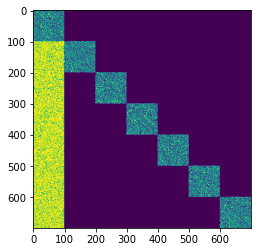

In [ ]:
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import Data
backwards_edge_index = dense_to_sparse(A.t())[0]
backwards_data = Data(x=data.x, edge_index=backwards_edge_index)

sparse_A = torch.sparse_coo_tensor(backwards_data.edge_index, torch.ones(backwards_data.edge_index.shape[1]))
A = sparse_A.to_dense()
plt.imshow(A)

converting graph to networkx...
getting embedding...
Embedding shape = (700, 64)
performing PCA...


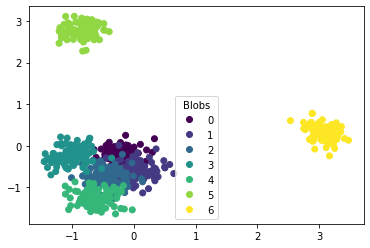

In [ ]:
walker = BackwardsRandomWalker(walk_number=10, walk_length=100, backwards_prob=0.05)
model = DeepWalkAugmented(walker, dimensions=64, window_size=5)

print("converting graph to networkx...")
G_nx = to_networkx(data, to_undirected=False)
bw_G_nx = to_networkx(backwards_data, to_undirected=False)

print("getting embedding...")
model.fit(G_nx, bw_G_nx)
embedding = model.get_embedding()
print(f"Embedding shape = {embedding.shape}")

print("performing PCA...")
pca = PCA(n_components=2)
pca_out= pca.fit_transform(embedding)
n_clusters= 7
clusters = np.repeat(list(range(n_clusters)), data.x.shape[1]/n_clusters)
sc = plt.scatter(pca_out[:, 0], pca_out[:, 1], c=clusters)
plt.legend(handles = sc.legend_elements()[0], title="Blobs", labels=list(range(n_clusters)))
plt.show()

## Simple 1 source 1 sink

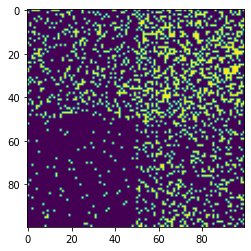

In [ ]:
from directed_graphs.datasets import DirectedStochasticBlockModel
aij = np.array([[0.4,0.4],[0.4,0.4]])
bij = np.array([[0.5,0.9],[0.1,0.5]])
dataset = DirectedStochasticBlockModel(num_nodes=100, num_clusters=2, aij = aij, bij = bij)
data = dataset[0] # there is only graph in this dataset
sparse_A = torch.sparse_coo_tensor(data.edge_index,torch.ones(data.edge_index.shape[1]))
A = sparse_A.to_dense()
plt.imshow(A)

converting graph to networkx...
getting embedding...
Embedding shape = (100, 64)
performing PCA...


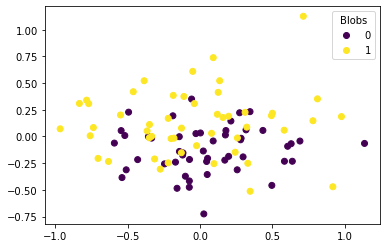

In [ ]:
walker = RandomWalker(walk_number=10, walk_length=100)
model = DeepWalkAugmented(walker, dimensions=64, window_size=5)

print("converting graph to networkx...")
G_nx = to_networkx(data, to_undirected=False)

print("getting embedding...")
model.fit(G_nx)
embedding = model.get_embedding()
print(f"Embedding shape = {embedding.shape}")

print("performing PCA...")
pca = PCA(n_components=2)
pca_out= pca.fit_transform(embedding)
n_clusters= 2
clusters = np.repeat(list(range(n_clusters)), data.x.shape[1]/n_clusters)
sc = plt.scatter(pca_out[:, 0], pca_out[:, 1], c=clusters)
plt.legend(handles = sc.legend_elements()[0], title="Blobs", labels=list(range(n_clusters)))
plt.show()

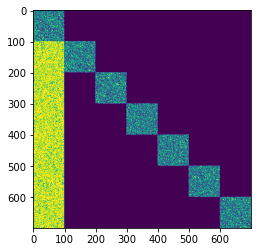

In [ ]:
from torch_geometric.data import Data
row, col = data.edge_index
backwards_edge_index = torch.stack([col, row])
backwards_data = Data(x=data.x, edge_index=backwards_edge_index)
backwards_sparse_A = torch.sparse_coo_tensor(backwards_data.edge_index, torch.ones(backwards_data.edge_index.shape[1]))
backwards_A = backwards_sparse_A.to_dense()
plt.imshow(backwards_A)

converting graph to networkx...
getting embedding...
Embedding shape = (100, 64)
performing PCA...


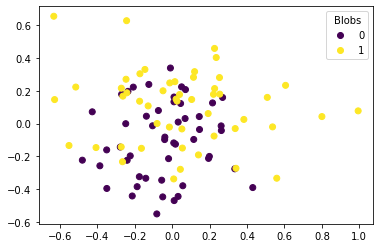

In [ ]:
walker = BackwardsRandomWalker(walk_number=10, walk_length=100, backwards_prob=0.05)
model = DeepWalkAugmented(walker, dimensions=64, window_size=5)

print("converting graph to networkx...")
G_nx = to_networkx(data, to_undirected=False)
bw_G_nx = to_networkx(backwards_data, to_undirected=False)

print("getting embedding...")
model.fit(G_nx, bw_G_nx)
embedding = model.get_embedding()
print(f"Embedding shape = {embedding.shape}")

print("performing PCA...")
pca = PCA(n_components=2)
pca_out= pca.fit_transform(embedding)
n_clusters= 2
clusters = np.repeat(list(range(n_clusters)), data.x.shape[1]/n_clusters)
sc = plt.scatter(pca_out[:, 0], pca_out[:, 1], c=clusters)
plt.legend(handles = sc.legend_elements()[0], title="Blobs", labels=list(range(n_clusters)))
plt.show()